# Magnetisation field

One of the main objects, which we have to be specify as a part of the micromagnetic system is the magnetisation field $\mathbf{M}$. In Ubermag, by defining the magnetisation field, the mesh, the geometry of the sample, as well as the magnetisation saturation $M_\text{s}$ are defined.

The Ubermag package we use to define finite difference regions, meshes, and fields is `discretisedfield` and we have to import it before we use it.

In [1]:
import discretisedfield as df  # df is just a shorter name

## Region

In finite differences, the region on which the mesh and the field are specified is always "cubic". In order to define a mesh, two points $p_{1}$ and $p_{2}$ must be passed to `discretisedfield.Region`. Those points correspond to two points between which the region spans.

For instance, if we want to define the following region:

$$x \in [0, 100]\,\text{nm}$$
$$y \in [-20, 20]\,\text{nm}$$
$$z \in [0, 10]\,\text{nm}$$

two points we need to pass are:

$$p_\text{1} = (0 \,\text{nm}, -20 \,\text{nm}, 0 \,\text{nm})$$
$$p_\text{2} = (100 \,\text{nm}, 20 \,\text{nm}, 10 \,\text{nm})$$

In Ubermag, points are defined as length-3 iterables, for instance, tuples. Accordingly, the region we want is:

In [2]:
p1 = (0, -20e-9, 0)  # point 1
p2 = (100e-9, 20e-9, 10e-9)  # point 2

region = df.Region(p1=p1, p2=p2)

There are several quantitites we can ask the region object for.

In [4]:
region.pmin  # minimum coordinate in the region

(0.0, -2e-08, 0.0)

In [5]:
region.pmax  # maximum coordinate in the region

(1e-07, 2e-08, 1e-08)

In [6]:
region.centre  # the region centre

(5e-08, 0.0, 5e-09)

In [7]:
region.edges  # edge lengths of the region

(1e-07, 4e-08, 1e-08)

We can visualise the region using either matplotlib `mpl()` or k3d `k3d()`.

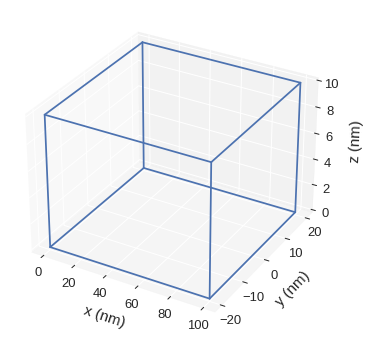

In [8]:
region.mpl()

In [9]:
region.k3d()

Output()

## Mesh

After the region is defined, we need to discretise it in order to define a mesh. There are two ways how a region can be discretised - by passing:

1. Discretisation cell size (`cell`), or
2. Number of discretisation cells in all three directions (`n`).

Let us say we want to discretise our region in cells of size $(10\,\text{nm}, 10\,\text{nm}, 10\,\text{nm})$. Then, we pass the region and the cell size to `Mesh` class.

In [10]:
cell = (10e-9, 10e-9, 10e-9)  # discretisation cell
mesh = df.Mesh(region=region, cell=cell)  # mesh definition

We can then inspect some basic parameters of the mesh.

In [11]:
mesh.n  # number of discretisation cells

(10, 4, 1)

In [12]:
len(mesh)  # total number of discretisation cells

40

We can visualise the region using either matplotlib `mpl()` or k3d `k3d()`.

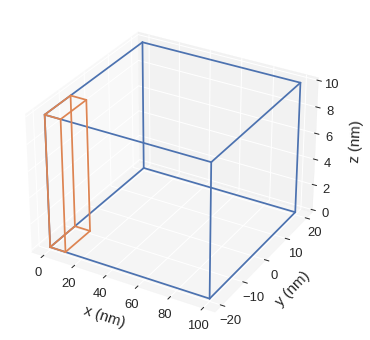

In [13]:
mesh.mpl()

In [14]:
mesh.k3d()

Output()

When we have the mesh object created, we can access the region using `.` operator. For instance:

In [15]:
mesh.region.centre

(5e-08, 0.0, 5e-09)

## Field

After we defined the mesh, we can define a finite difference field. For that, we use `Field` class. We must provide the following 3 mandatory parameters:

1. mesh (`mesh` as `discretisedfield.Mesh`),
2. dimension of the value (e.g. `dim=1` for scalar, `dim=3` for vector),
3. value of the field (`value`).

For instance, let us define a 3D-vector field (`dim=3`) that is uniform in the $x$-direction `value=(1, 0, 0)` direction.

In [16]:
m = df.Field(mesh, dim=3, value=(1, 0, 0))

A simple visualisation of the field in $z$-slice through the middle is:

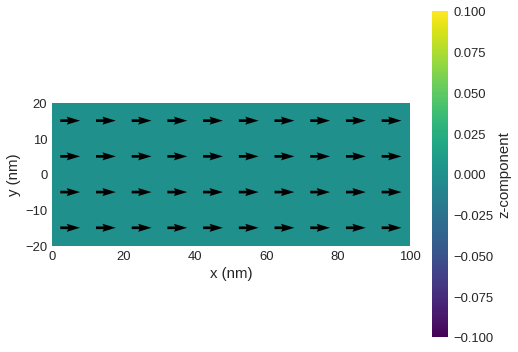

In [17]:
m.plane('z').mpl()

Similarly, a three-dimensional interactive plot is:

In [18]:
m.k3d_vector(head_size=20)

Output()

The average value of the field is:

In [19]:
m.average

(1.0, 0.0, 0.0)

We can specify the norm of the field, by passing `norm` parameter. In the case of magnetisation, norm corresponds to magnetisation saturation $M_\text{s}$.

In [20]:
Ms = 8e6  # A/m
m = df.Field(mesh, dim=3, value=(0, 0, 1), norm=Ms)

Now, if we have a look at the average:

In [21]:
m.average

(0.0, 0.0, 8000000.0)

### Spatially varying field value

When we defined a uniform vector field, we used a tuple `value=(1, 0, 0)` to define its value. However, we can also pass a callable (e.g. Python function) if we want to define a non-uniform field. This function takes the coordinate of the mesh cell as an input, and returns a value that the field should have at that point. The function must be defined at all points in the mesh.

In [22]:
def m_value(point):
    x, y, z = point  # unpack position into individual components
    if y > 0:
        return (1, 0, 0)  # return, not print
    else:
        return (-1, 1, 0)
    
m = df.Field(mesh, dim=3, value=m_value)

Now, we can plot it using `mpl`.

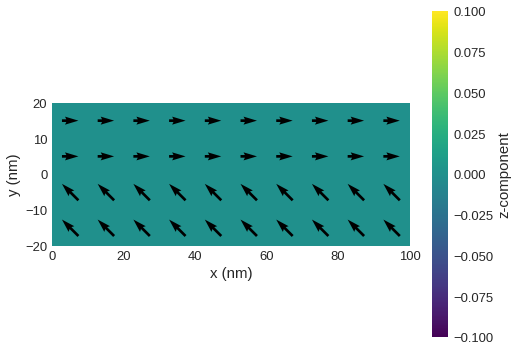

In [23]:
m.plane('z').mpl()

The field object can be treated as a callable - if we pass a point to the function, it will return the vector value of the field at that location:

In [24]:
point = (0, -10e-9, 0)
m(point)

(-1.0, 1.0, 0.0)

In [25]:
point = (0, 10e-9, 0)
m(point)

(1.0, 0.0, 0.0)

In [26]:
m(m.mesh.region.centre)

(1.0, 0.0, 0.0)

### Spatially varying $M_\mathrm{s}$

By defining a norm of a field, we can specify different geometries. More precisely, we can set $M_\text{s}=0$ where no magnetic material is present. For instance, let us assume we want to define a sphere of radius $r=50\,\text{nm}$, disrectised by 10 cells in each direction, and magnetise it in the negative $y$-direction.

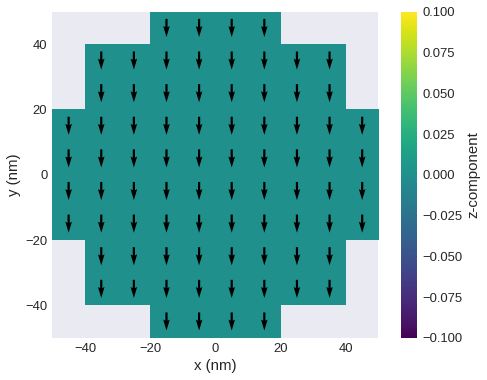

In [27]:
r = 50e-9
n = (10, 10, 10)
region = df.Region(p1=(-r, -r, -r), p2=(r, r, r))
mesh = df.Mesh(region=region, n=n)

def Ms_value(point):
    x, y, z = point
    if x**2 + y**2 + z**2 < r**2:
        return Ms
    else:
        return 0

m = df.Field(mesh, dim=3, value=(0, -1, 0), norm=Ms_value)

m.plane('z').mpl()

We can inspect the defined domain using k3d and inspecting the field's norm.

In [28]:
m.norm.k3d_nonzero()

Output()

## Example

Let us define a thin-film disk sample of thickness $t = 10 \,\text{nm}$ and diameter $d = 120 \,\text{nm}$. The saturation magnetisation $M_\mathrm{s} = 10^{7}\mathrm{A/m}$. The disk is centred at the origin (0, 0, 0) and the magnetisation is $\mathbf{m} = (1, 0, 0)$ at all mesh points.

In [29]:
t = 10e-9  # thickness (m)
d = 120e-9  # diameter (m)
cell = (5e-9, 5e-9, 5e-9)  # discretisation cell size (m)
Ms = 1e7  # saturation magnetisation (A/m)

region = df.Region(p1=(-d/2, -d/2, -t/2), p2=(d/2, d/2, t/2))
mesh = df.Mesh(region=region, cell=cell)

def Ms_value(point):
    x, y, z = point
    if (x**2 + y**2)**0.5 < d/2:
        return Ms
    else:
        return 0
   
m = df.Field(mesh, dim=3, value=(1, 0, 0), norm=Ms_value)

m.norm.k3d_nonzero()

Output()

Now, let us say we want to extend the solution from the previous example so that the magnetisation is:

$$\mathbf{m} = \begin{cases} (-1, 0, 0) & \text{for } y \le 0 \\ (1, 1, 1) & \text{for } y > 0 \end{cases}$$

with saturation magnetisation $M_\text{s} = 10^{7} \,\text{A}\,\text{m}^{-1}$.

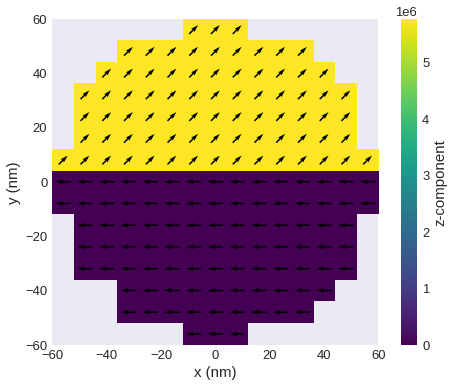

In [30]:
def m_value(pos):
    x, y, z = pos
    if y <= 0:
        return (-1, 0, 0)
    else:
        return (1, 1, 1)
    
m = df.Field(mesh, dim=3, value=m_value, norm=Ms_value)

m.plane('z', n=(15, 15)).mpl()

## Exercise

Define the following sample with $10\,\text{nm}$ thickness:

   <img src="figures/geometry_exercise2.png" width="400">  

The magnetisation saturation is $M_\mathrm{s} = 8 \times 10^{6} \,\mathrm{A}\,\mathrm{m}^{-1}$ and the magnetisation direction is as shown in the figure.

**Solution**

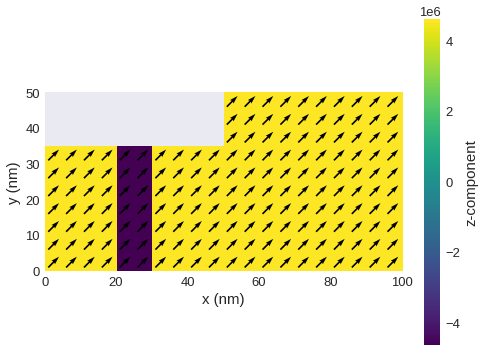

In [31]:
cell = (5e-9, 5e-9, 5e-9)  # discretisation cell size (m)
Ms = 8e6  # saturation magnetisation (A/m)

region = df.Region(p1=(0, 0, 0), p2=(100e-9, 50e-9, 10e-9))
mesh = df.Mesh(region=region, cell=cell)

def Ms_value(pos):
    x, y, z = pos
    if x < 50e-9 and y > 35e-9:
        return 0
    else:
        return Ms
    
def m_value(pos):
    x, y, z = pos
    if 20e-9 < x <= 30e-9:
        return (1, 1, -1)
    else:
        return (1, 1, 1)
    
m = df.Field(mesh, dim=3, value=m_value, norm=Ms_value)

m.plane('z').mpl()